# Selección de variables y regularización
_Santander Meteorology Group (18-01-2022)_

 * [Introducción](#Introducción)
 * [Base de datos de ejemplo: Breast cancer](#Base-de-datos:-Breast-cancer)
 * [Modelo lineal completo](#Modelo-lineal-completo)
 * [Selección de variables](#Selección-de-variables)
 * [Regularización](#Regularización)

## Introducción
El objetivo principal de un modelo entrenado es que tenga la capacidad de generalizar, es decir, la capacidad de predecir bien nuevos datos que no formen parte de la muestra de entrenamiento (por ejemplo, una muestra de datos de *test*). La relación entre el número de observaciones y el número de variables independientes es clave en la capacidad de generalización de los modelos.

Para evitar el sobreajuste en situaciones donde el número de observaciones es del orden, o menor, que el de grados de libertad del sistema y/o donde hay colinealidad, se utilizan (entre otras) técnicas como la selección de variables y la regularización. La primera permite seleccionar de forma objetiva un subconjunto de variables predictoras, mientras que la segunda actúa sobre los parámetros del modelo, impidiendo que tomen valores elevados que harían al modelo muy sensible a diferentes muestras de entrenamiento.

## Base de datos: Breast cancer

En este ejemplo trabajaremos con la base de datos [_Breast cancer_ (Diagnostic)](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), incluida en Kaggle. El objetivo de este conjunto de datos es clasificar a las pacientes en base a si el cáncer de mama que tienen es benigno (`B`) o maligno (`M`). Pamra ello se utilizan 31 predictores relacionados con las propiedades de las células cancerígenas, que en comparación con el número de observaciones (569) es bajo.

Leemos la base de datos:

In [1]:
datos <- read.csv("breastcancer.csv")
str(datos)

'data.frame':	569 obs. of  33 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se            

Y la preparamos la base de datos de la siguiente manera:

In [2]:
# Eliminar no predictores (id y última columna vacía)
df <- datos[, -c(1, ncol(datos)-1, ncol(datos))]
# Convertir el factor diagnosis (B y M) a los valores numéricos 0 y 1, respectivamente.
df$diagnosis <- as.numeric(df$diagnosis)-1
# Normalizar los datos (predictores o features) para evitar problemas de diferente variabilidad
df[-1] <- apply(df[-1], MARGIN = 2, scale)
rm(datos)
dim(df)
head(df)

[1] 569  30

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,⋯,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.0960995,-2.0715123,1.2688173,0.9835095,1.5670875,3.2806281,2.65054179,2.5302489,2.215565542,⋯,0.90628565,1.8850310,-1.35809849,2.3015755,1.9994782,1.3065367,2.6143647,2.1076718,2.2940576,2.7482041
2,1,1.8282120,-0.3533215,1.6844726,1.9070303,-0.8262354,-0.4866435,-0.02382489,0.5476623,0.001391139,⋯,-0.09935632,1.8043398,-0.36887865,1.5337764,1.8888270,-0.3752817,-0.4300658,-0.1466200,1.0861286,-0.2436753
3,1,1.5784992,0.4557859,1.5651260,1.5575132,0.9413821,1.0519999,1.36227979,2.0354398,0.938858720,⋯,0.29330133,1.5105411,-0.02395331,1.3462906,1.4550043,0.5269438,1.0819801,0.8542223,1.9532817,1.1512420
4,1,-0.7682333,0.2535091,-0.5921661,-0.7637917,3.2806668,3.3999174,1.91421287,1.4504311,2.864862154,⋯,2.04571087,-0.2812170,0.13386631,-0.2497196,-0.5495377,3.3912907,3.8899747,1.9878392,2.1738732,6.0407261
5,1,1.7487579,-1.1508038,1.7750113,1.8246238,0.2801253,0.5388663,1.36980615,1.4272370,-0.009552062,⋯,0.49888916,1.2974336,-1.46548091,1.3373627,1.2196511,0.2203623,-0.3131190,0.6126397,0.7286181,-0.8675896
6,1,-0.4759559,-0.8346009,-0.3868077,-0.5052059,2.2354545,1.2432416,0.86554001,0.8239307,1.004517928,⋯,0.48641784,-0.1653528,-0.31356043,-0.1149083,-0.2441054,2.0467119,1.7201029,1.2621327,0.9050914,1.7525273


Podemos comprobar que hay colinealidades en los datos

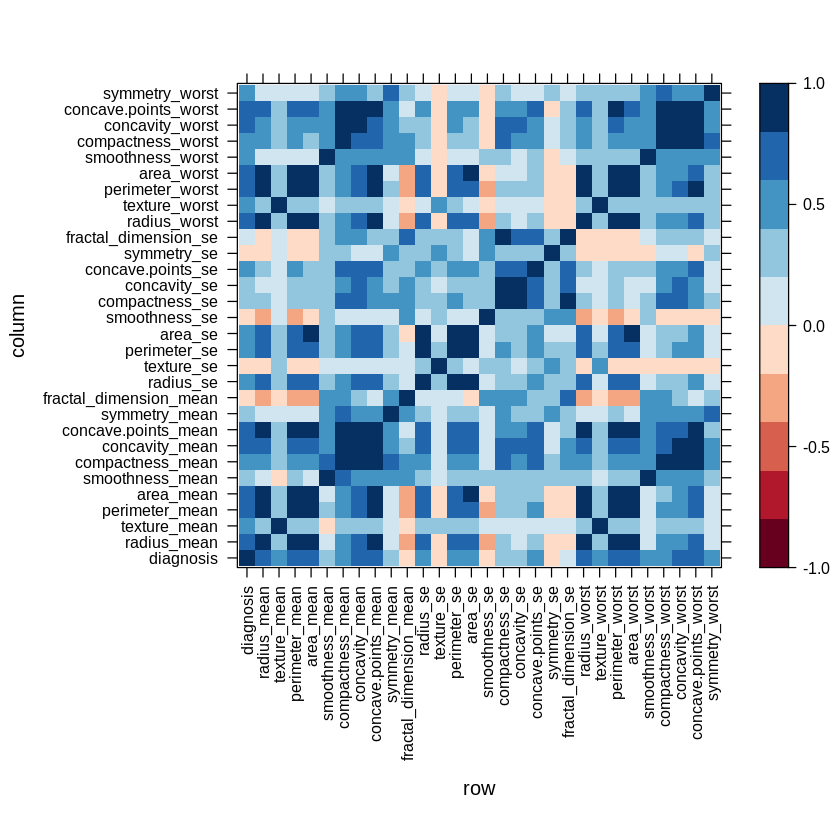

In [3]:
library(RColorBrewer) # brewer.pal
library(lattice) # levelplot
colores <- brewer.pal(10,"RdBu")
levelplot(cor(df), # ó simplemente image(cor(df))
  at = seq(-1, 1, 0.2), col.regions = colores,
  scale = list(x = list(rot = 90)) # gira 90º las etiquetas del eje X
)

## Modelo lineal completo

Construyamos el modelo lineal mediante la función `glm`. Como la variable respuesta sigue una distribución de Bernouilli lo más apropiado es realizar una regresión logística, es decir: familia binomial, link _logit_ (por defecto para esta familia).

In [4]:
model <- glm(diagnosis ~ ., data = df, family = "binomial") # ídem family =  binomial(link = "logit"), ver ?family
pred  <- predict(model, type = "response") # type = "response" devuelve las probabilidades predichas entre 0 y 1.

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Vemos que surgen algunas alertas sobre la convergencia del algoritmo (probablemente debidas a las colinealidades en nuestros predictores) y de sobreajuste (predicciones deterministas de 0 o 1).

Para comprobar la capacidad predictiva de nuestro modelo en la clasificación del cáncer de mama, utilizaremos el índice Área bajo la curva ROC (AUC, por sus siglas en inglés) disponible en las librerías `verification` y `pROC`.

In [5]:
# Paquete verification para ROC y roc area
# options(download.file.method="wget") # esta línea es necesaria en el HUB para instalar paquetes a través de una url
# install.packages("verification")
library(verification, quietly = TRUE) # roc.area
auc <- roc.area(obs = df$diagnosis,pred)$A
roc.plot(df$diagnosis, pred, main=sprintf("Curva ROC (AUC=%g)", auc))

ERROR: Error in library(verification, quietly = TRUE): there is no package called ‘verification’


In [ ]:
# Análogamente con el paquete pROC
#install.packages("pROC")
library(pROC) 
roc_obj <- roc(df$diagnosis, pred)
auc(roc_obj)
plot.roc(roc_obj,print.auc=T, print.thres = "best")

También podríamos comprobar los resultados del modelo en una tabla de contingencia (_confusion matrix_), pero en este caso necesitamos convertir las predicciones probabilistas del modelo en valores cualitativos (factores) deterministas. Para ello usamos un umbral de decisión. En este ejemplo usamos 0.5 como umbral; prueba a modificarlo para ver el efecto sobre los aciertos del modelo (esto es lo que hace la curva ROC).

In [ ]:
#install.packages("caret")
library(caret, quietly = TRUE) # confusionMatrix
confusionMatrix(as.factor(as.numeric(pred>0.5)), as.factor(df$diagnosis), positive="1")


# Alternativa sin usar caret
outbin <- as.double(pred > 0.5)
table(df$diagnosis, outbin, dnn=c("Ref.","Pred."))
# Accuracy
100*sum(diag(table(df$diagnosis, outbin))) / length(outbin)

**TAREA 1:** Estudiar la capacidad de generalización del modelo completo mediante una validacion cruzada de tipo *hold out*, es decir, utilizando una parte de los datos para entrenar el modelo y reservando otra para probarlo.

## Selección de variables



### Selección del mejor subconjunto

La función `regsubsets` (`?regsubsets`) de la librería `leaps` nos permite realizar la selección del mejor subconjunto con un número dado de predictores. La sintaxis es similar a la usada para el modelo lineal (`lm`) y, del mismo modo, el comando `summary` nos permite explorar los resultados. Utilizamos el argumento `nvmax` para forzar la utilización de todas las variables (30), ya que por defecto la función regsubsets solo utiliza las 8 primeras.

In [ ]:
#install.packages('leaps')
library(leaps)
regfit.full <- regsubsets(diagnosis ~., df, nvmax = 30) # por defecto method="exhaustive"

La función `summary` devuelve medidas del ajuste que se pueden usar para seleccionar el mejor modelo.

In [ ]:
full.summary <- summary(regfit.full)
names(full.summary)

En particular, si revisamos los valores del ajuste, en este caso rsq ($R^2$, el coeficiente de determinación), se observa que el estadístico va mejorando a medida que aumentamos el número de variables en el modelo. No puede ser de otra manera, ya que este estadístico está relacionado con la varianza explicada por nuestro modelo, que aumenta monótonamente al incluir variables adicionales. Sin embargo, si nos fijamos en el estadístico BIC (*Bayesian information criterion*), que penaliza la complejidad del modelo (el número de variables predictoras), se observa que los valores óptimos se encuentran considerando 11 variables.

In [ ]:
scores <- c("rsq", "bic")
par(mfrow=c(length(scores),1), mar=c(4,4,1,1))
for (score in scores){
  plot(full.summary[[score]], xlab="Number of Variables", ylab=score, type="l")
}

In [ ]:
which.min(full.summary$bic)

La propia función `regsubsets` incorpora un método para dibujar los resultados clasificados según los diferentes estadísticos (`? plot.regsubsets`)

In [ ]:
plot(regfit.full, scale ="r2")
#plot(regfit.full, scale ="bic")

Cada fila de este gráfico representa el mejor modelo ajustado para un número dado de variables. Cada cuadrado de color representa que la variable entra en ese modelo, mientras que la intensidad del color se asocia con la escala del eje Y.

Una vez localizado el modelo óptimo (en nuestro caso, el de 11 variables), si queremos conocer los coeficientes del modelo, podemos usar la función `coef` con un segundo argumento:

In [ ]:
coef(regfit.full, 11)

### Selección stepwise
Al no haber especificado método de selección, la búsqueda del mejor modelo de la sección anterior ha sido exhaustiva. Con un leve cambio en los argumentos de la función podemos realizar la selección _stepwise_, ya sea “forward” o “backward”:

In [ ]:
regfit.fwd <- regsubsets(diagnosis~., data = df, nvmax = 30 , method ="forward")
fwd.summary <- summary(regfit.fwd)

**TAREA 2:** Estudiar los predictores seleccionados en este caso. ¿cuál es su número óptimo? ¿coinciden con los anteriores?

**TAREA 3:** Comparar la selección realizada por el método _backward_ con los métodos exhaustivo y _forward stepwise_.

### Selección mediante la función step
Otra opción para realizar la selección _stepwise_ es usar la función `step`, que forma parte del paquete básico `stats` de R:

In [ ]:
initialModel_0 <- glm(diagnosis ~ 1, data = df, family=binomial(link="logit"))
initialModel_p <- glm(diagnosis ~ ., data = df, family=binomial(link="logit"))

fw <- step(initialModel_0,
  scope = list(lower = formula(initialModel_0), upper = formula(initialModel_p)),
  direction = "forward"
)
summary(fw)

El objeto de salida es una lista que contiene múltiples elementos. Entre ellos, ilustramos el resultado anova, que muestra las variables seleccionadas (10 en este caso) en orden de adición y el AIC correspondiente (similar al estadístico BIC) .

In [ ]:
fw$anova

## Regularización
La regularización consiste en añadir un término a la función objetivo que elimine predictores (regularización L1) o disminuya notablemente su influencia (regularización L2) de tal manera que su capacidad de generalización mejore. El coeficiente estimado estará sesgado, debido al término extra que se ha añadido a la función objetivo, sin embargo su varianza puede disminuir. Este equilibrio entre el sesgo y la varianza es lo que se conoce como _bias-variance tradeoff_. Si el modelo está demasiado sesgado entonces no se capturarán correctamente las relaciones entre predictando y predictor, sin embargo si está muy poco sesgado, la varianza del coeficiente estimado puede ser alta y no generalizar bien.

En R, para regularizar modelos lineales generalizados se utiliza el paquete `glmnet`. El tipo de regularización viene dado por el valor del parámetro `alpha`: para una regularización L1, `alpha = 1`, para una regularización L2, `alpha = 0`. Ambos tipos de regularización penalizan la norma (1 ó 2, en función de si la regularización es L1 o L2) del vector de coeficientes estimados. Una consecuencia de la regularización L1 es que indirectamente selecciona variables al hacer estrictamente 0 algunos coeficientes. El número de coeficientes que se hacen 0 viene determinado por el valor de `lambda`. El valor de lambda óptimo se obtiene mediante validación cruzada a través de la función `cv.glmnet`.

En primer lugar, debemos instalar y cargar las librerías que utilizaremos en los ejemplos:

In [ ]:
#install.packages("glmnet")
library(glmnet, quiet = TRUE)

### Regularización L1 (LASSO)
Veamos qué nos puede aportar una regularización L1 en este caso. La función `glmnet`nos permite representar directamente la evolución de los coeficientes del modelo para un rango de valores de $\lambda$.

In [ ]:
fit <- glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 1) # valores de lambda por defecto, nlambda=100
plot(fit, label=TRUE, xvar = "lambda") # representa los coeficientes frente al log neperiano de lambda

En la parte superior se muestra el número de coeficientes no nulos para cada valor de $\lambda$. Vemos como muchos se hacen 0 al ir aumentando $\lambda$.

Para estimar el valor óptimo de $\lambda$ recurrimos a una validación cruzada mediante la función `cv.glmnet`:

In [ ]:
cvfit <- cv.glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 1)
print(cvfit)
plot(cvfit)

Con este valor de lambda estimado, podemos entrenar el modelo regularizado mediante la función `glmnet`:

In [ ]:
model.l1 <- glmnet(as.matrix(df[,-1]), df$diagnosis, family = "binomial", alpha = 1, lambda = cvfit$lambda.1se)
coef(model.l1) # coeficientes del modelo
ind.coef.no.nulos <- which(as.numeric(coef(model.l1)) != 0)
names(df)[ind.coef.no.nulos] # coeficientes no nulos
cat(paste("Number of variables selected:", length(ind.coef.no.nulos)))

Vemos que efectivamente la regularización L1 ha hecho 0 muchos coeficientes eliminando grados de libertad del sistema, salvo las características que se observan en la salida anterior.

En realidad, no es necesario invocar de nuevo glmnet. El objeto que devuelve la validación cruzada también contiene los coeficientes correspondientes al $\lambda$ óptimo.

In [ ]:
coef(cvfit)

Y podemos solicitar también los del $\lambda$ que minimiza la validación cruzada:

In [ ]:
coef(cvfit, s="lambda.min")

Podemos ver el sobreajuste de forma cualitativa con la curva ROC:

In [ ]:
pred.l1 <- predict(cvfit, as.matrix(df[-1]), type = "response")
auc.l1 <- roc.area(df$diagnosis,pred.l1)$A
roc.plot(df$diagnosis, pred.l1, main=sprintf("Curva ROC Regularización L1 (AUC = %g)", auc.l1))

Observamos como, aún con solo 11 variables, el AUC es todavía bastante alto. Por ello se propone la siguiente tarea.

**TAREA 4:** Utilizar una validación cruzada tipo _hold out_ para comprobar si la capacidad de generalización del modelo ha mejorado con la regularización L1.

### Regularización L2 (ridge)
Si probásemos con la regularización L2 (parámetro `alpha = 0`), la norma-2 (norma euclídea) del vector de coeficientes se limita pero en este caso ningún coeficiente llega a anularse.

In [ ]:
cvfit2 <- cv.glmnet(as.matrix(df[-1]), df$diagnosis, family = "binomial",alpha = 0)
ind.coef.no.nulos.l2 <- which(as.numeric(coef(cvfit2)) != 0)
cat(paste("Number of variables selected:", length(ind.coef.no.nulos.l2)))

Calculamos el AUC para el modelo regularizado con el penalty L2.

In [ ]:
pred.l2 <- predict(cvfit2, as.matrix(df[-1]), type = "response")
auc.l2 <- roc.area(df$diagnosis, pred.l2)$A
roc.plot(df$diagnosis, pred.l2, main=sprintf("Curva ROC Regularización L2 (AUC = %g)", auc.l2))

**TAREA 5:** Comprobar la capacidad de generalización del modelo regularizado mediante _ridge regression_ y estudiar la evolución de los valores de los coeficientes en función del valor de `lambda`.

**TAREA 6:** Aplicar lo aprendido en esta práctica a otra de las bases de datos de ejemplo.